행렬과 벡터 계산

간단한 수학 방정식을 푸는 동안 CPU에서 일어나는 일을 이해하면서 파이썬 코드에 따라 CPU가 어떻게 다르게 쓰이는 지 이해한다.

- 벡터 연산 병목 지점의 위치
- 계산 과정 중에 CPU를 효율적으로 사용하는 지 알아볼 수 있는 도구:perf
- 산술 게산에서 numpy가 순수 파이썬보다 더 빠른 이유
- 캐시 미스와 페이지 폴트
- 코드 내에서 메모리 할당을 추적하는 방법

# 6.1 문제 소개


수학 방정식: 유체확산 예제

- 주기적 경계조건: 색인에 나머지 연산을 적용한다.
- dt값:
- 격자항목: 

- 벡터 배열을 가지기 때문에 적합한 예시
- 벡터:한 가지 타입의 여러 개의 원소를 변수에 저장한 배열
- 벡터연산: 벡터의 같은 인덱스에 위치한 원소들끼리 연산을 수행하는 기능

Python for loops are inherently slower than their C counterpart.
This is why numpy offers vectorized actions on numpy arrays. It pushes the for loop you would usually do in Python down to the C level, which is much faster. numpy offers vectorized ("C level for loop") alternatives to things that otherwise would need to be done in an element-wise manner ("Python level for loop).

```
>>> import numpy as np
>>> arr = np.array([[1., 2., 3.], [4., 5., 6.]])
>>> arr * arr
array([[  1.,   4.,   9.],
       [ 16.,  25.,  36.]])
       
>>> arr = arr.tolist()
>>> res = [[0., 0., 0.], [0., 0., 0.]]
>>> for idx1, row in enumerate(arr):
        for idx2, val2 in enumerate(row):
            res[idx1][idx2] = val2 * val2
>>> res
[[1.0, 4.0, 9.0], [16.0, 25.0, 36.0]]

```

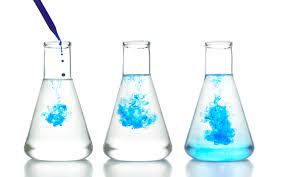

In [1]:
# 단순 1차원 확산 의사코드

# 초기 조건 생성
u = vector of length N
for i in range(N):
    u = 0 if there is water, 1 if there is dye

# 초기 조건 변경
D = 1
t = 0
dt = 0.001
whiile True:
    print("current time is ", f)
    unew = vector of size N
    
    # 행렬의 각 셀 갱신
    for i in range(N):
        unew[i] = u[i] + D*dt*( u[(i+1) % N] + u[(i-1) % N] - 2 * u[i])

SyntaxError: invalid syntax (<ipython-input-1-4b066337e7b2>, line 4)

In [2]:
# 2차원 확산 의사코드 (vectorization)

for i in range(N):
    for j in range(M):
        unew[i][j] = u[i][j] + dt * (
            (u[(i+1)%N][j] + u[(i-1)%N][j] -2*u[i][j])+
            (u[i][(j+1)%M] + u[i][(j-1)%M] -2*u[j][i])
        )

NameError: name 'N' is not defined

# 6.2 파이썬의 리스트만으로 충분할까?

python의 for 문을 이용하자

In [4]:
# 초기화 조건

def run_experiment(num_iterations):
    # setting up initial conditions
    grid = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]

    # 잉크를 넣는다.
    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
    
    #원하는 횟수만큼 진행시킨다
    start = time.time()
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
    return time.time() - start

In [ ]:
# 행렬을 받아 변환된 상태를 반환하는 evolve 함수, 반복적으로 사용된다.
# evolve: 진행하는 함수

grid_shape = (640, 640)

def evolve(grid, dt, D=1.0):
    xmax, ymax = grid_shape
    new_grid = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = (
                grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
            )
            grid_yy = (
                grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
            )
            new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
    return new_grid



## 6.2.1 너무 잦은 할당의 문제

evolve의 실행속도를 느리게 만드는 원인은 무엇일까?
TIP:  py -m line_profiler diffusion_python.py.lprof> result.txt ( binary to txt)

1) line_profiling > new_grid  를 매번 반복해서 메모리 할당을 하고 있었다.

```
Timer unit: 1e-06 s

Total time: 1164.81 s
File: diffusion_2d/diffusion_python.py
Function: evolve at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    13                                           @profile
    14                                           def evolve(grid, dt, D=1.0):
    15       500       1069.7      2.1      0.0      xmax, ymax = grid_shape 
    # 차지하는 비중은 작지만 한 번 돌아가는 데에 시간이 많이 걸린다.> 병목부분
    16       500   30611342.5  61222.7      2.6      new_grid = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]
    17    320500     243087.4      0.8      0.0      for i in range(xmax):
    18 205120000  140356617.0      0.7     12.0          for j in range(ymax):
    19 204800000  140209115.1      0.7     12.0              grid_xx = (
    20 204800000  255624591.0      1.2     21.9                  grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
    21                                                       )
    22 204800000  140343828.5      0.7     12.0              grid_yy = (
    23 204800000  250255139.0      1.2     21.5                  grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
    24                                                       )
    25 204800000  207160780.3      1.0     17.8              new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
    26       500        504.5      1.0      0.0      return new_grid


```

gird의 메모리 주소값
```
$ py diffusion_2d/diffusion_python.py
address: 1838152352576
address: 1838152347392
address: 1838152389120
address: 1838152339968
address: 1838152360448
address: 1838152331776
address: 1838152385024
address: 1838152323584
address: 1838152413696
address: 1838152348160
address: 1838152372736
```


In [ ]:
# new_grid를  for loop 바깥으로 뺀다


@profile
def evolve(grid, dt, out, D=1.0):
    xmax, ymax = grid_shape
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = (
                grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
            )
            grid_yy = (
                grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
            )
            out[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt


def run_experiment(num_iterations):
    # setting up initial conditions
    scratch = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]
    grid = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]

    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.005

    start = time.time()
    for i in range(num_iterations):
        evolve(grid, 0.1, scratch)
        grid, scratch = scratch, grid
        print(grid, scratch)
    return time.time() - start

*C.F. 파이썬이 메모리를 할당하는 방식*

# 6.3  메모리 단편화

## 6.3.1 pref 이해하기

```
 Performance counter stats for 'python diffusion_python.py':

   444,281,397,352      cycles                    #    2.889 GHz              --------> 1사이클에 걸린 클락수
 1,292,776,966,318      instructions              #    2.91  insn per cycle   ---------> 1사이클 당 실행한 명령어의 수        
       902,297,518      cache-references          #    5.868 M/sec             ---------> cache hit에 걸린 시간     
       337,237,800      cache-misses              #   37.375 % of all cache refs  ------->  cache miss 횟수
   268,033,459,921      branches                  # 1743.051 M/sec                    ------->  분기예측 횟수
     1,845,293,511      branch-misses             #    0.69% of all branches         -------> 잘못 예측한 경우
     153772.569474      task-clock (msec)         #    1.000 CPUs utilized          ------->
         1,569,793      faults                    #    0.010 M/sec                -------> 페이지 폴트 - 디스크  access
         1,569,793      minor-faults              #    0.010 M/sec       -------> 페이지 폴트 (지정 메모리를 찾지 못한 경우)
               294      cs                        #    0.002 K/sec                  
                11      migrations                #    0.000 K/sec        -------> 멀티 코어끼리의 이동   

     153.776786975 seconds time elapsed    ------->  총걸린시간

```

## 6.3.2 perf 결과 반영하기

### 파이썬에서 vectorization을 사용하지 못하는 이유

#### (1) 리스트에는 포인터가 저장되어 있다. -> 

##### 항상  dynamically type 확인필요 ->  행렬에서 원소를 하나 꺼낼 때마다 확인한다
** 바이트 코드: When we execute a source code (a file with a . py extension), Python first compiles it into a bytecode. The bytecode is a low-level platform-independent representation of your source code, however, it is not the binary machine code and cannot be run by the target machine directly. 소스 코드(확장자가 .py인 파일)를 실행할 때 Python은 먼저 이를 바이트 코드로 컴파일합니다. 바이트코드는 소스 코드의 낮은 수준의 플랫폼 독립적 표현이지만 바이너리 기계 코드가 아니며 대상 시스템에서 직접 실행할 수 없습니다.
(2장의 바이트코드) - 파이썬 바이트코드는 벡터 연산에 최적화 되어있지 않다. 

#####  메모리 단편화: 
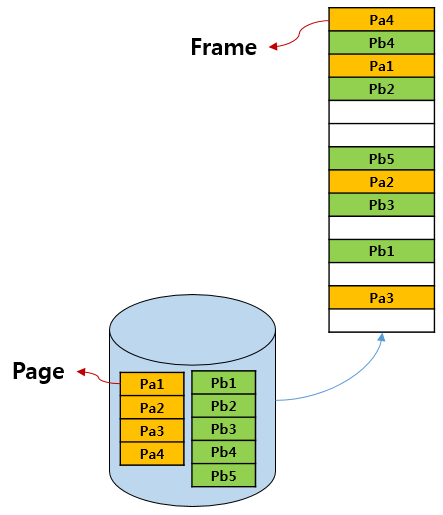

[메모리 단편화, 캐싱, 파이프라이닝, 분기예측]
http://egloos.zum.com/happyworld/v/1277339

##### CPU 게이트: 멜트다운, 스펙터

https://namu.wiki/w/CPU%20%EA%B2%8C%EC%9D%B4%ED%8A%B8?from=CPU%EA%B2%8C%EC%9D%B4%ED%8A%B8#s-3.1

#####  perf로 단편화 확인

```

 Performance counter stats for 'python diffusion_python_memory.py':


벡터연산을 하려면 연속적으로 캐시에 모두 올라가야한다.
연속 -> array (tuple)을 사용하면 느려지고
list를 사용하면 데이터가 조각나있어서 너무 느리고....

      349,562,390      cache-misses              #   53.259 % of all cache refs


   415,864,974,126      cycles                    #    2.889 GHz                      
 1,210,522,769,388      instructions              #    2.91  insn per cycle           
       656,345,027      cache-references          #    4.560 M/sec                    
       349,562,390      cache-misses              #   53.259 % of all cache refs      
   251,537,944,600      branches                  # 1747.583 M/sec                    
     1,970,031,461      branch-misses             #    0.78% of all branches          
     143934.730837      task-clock (msec)         #    1.000 CPUs utilized          
            12,791      faults                    #    0.089 K/sec                  
            12,791      minor-faults              #    0.089 K/sec                  
               117      cs                        #    0.001 K/sec                  
                 6      migrations                #    0.000 K/sec                  

     143.935522122 seconds time elapsed


```

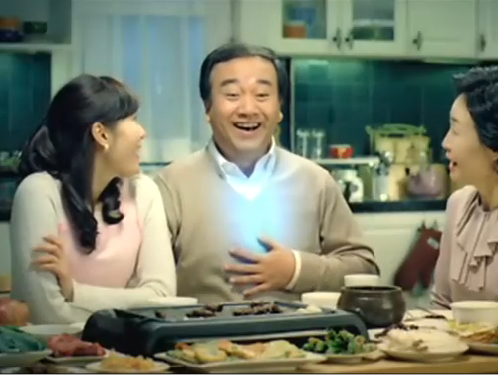

##  6.3.3 Numpy 입문

for문처럼 순서대로 도는 것이 아니라 여러 요소를 한번에 처리한다.
이로인해 행렬 연산이 간단, 빨라진다.

##  6.4 넘파이를 이용한 확산 방정식 해법

np.roll(): array를 벡터화 한다.(연산을 한번에 처리한다) 그리고 연속적으로 배정하기 떄문에 단편화된 native python에 비해 캐시를 이용해 메모리 관리를 더 효율적으로 한다.(캐시미스가 줄어든다)

- numpy.roll(): 파이썬 코드에서 사용한 **나머지 연산**을 전체 numpy배열에 적용해준다. 새로운 numpy 배열을 생성한다. 
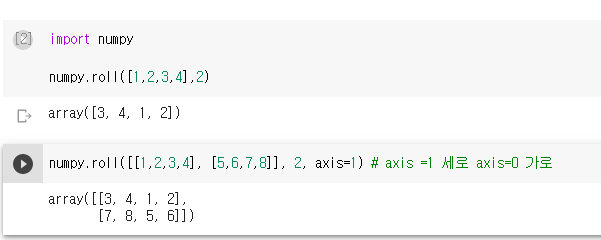

```
def laplacian(grid):
    return (
        roll(grid, +1, 0)
        + roll(grid, -1, 0)
        + roll(grid, +1, 1)
        + roll(grid, -1, 1)
        - 4 * grid
    )


@profile
def evolve(grid, dt, D=1):
    return grid + dt * D * laplacian(grid)


def run_experiment(num_iterations):
    grid = zeros(grid_shape)

    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    grid[block_low:block_high, block_low:block_high] = 0.005

    start = time.time()
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
    return time.time() - start


if __name__ == "__main__":
    run_experiment(500)

```



```

 Performance counter stats for 'python diffusion_numpy.py':

     8,432,416,866      cycles                    #    2.886 GHz                      
     7,114,758,602      instructions              #    0.84  insn per cycle  ---------->   한 사이클 당 명령어의 수가 줄어들었다.     
     1,040,831,469      cache-references          #  356.176 M/sec                    
       216,490,683      cache-misses              #   20.800 % of all cache refs--------->    53.259 % of all cache r에서 20%대로 줄어듦
     1,252,928,847      branches                  #  428.756 M/sec                    
         8,174,531      branch-misses             #    0.65% of all branches          
       2922.239426      task-clock (msec)         #    1.285 CPUs utilized          
           403,282      faults                    #    0.138 M/sec                  
           403,282      minor-faults              #    0.138 M/sec                  
                96      cs                        #    0.033 K/sec                  
                 5      migrations                #    0.002 K/sec                  

       2.274377105 seconds time elapsed  -----------------------------------------------> 속도가 빨라졌다


```

==> numpy의 벡터화 연산 덕분에 성능향상
- 실행되는 명령어가 줄어든 이유는 python 에 있지만 num에는 없는API들.
- 한 사이클 당 실행하는 명령어는 줄었지만 명령어 수 자체가 줄어든다.
- 벡터의 연산기능 제외(실행할 때 FOPT= -fno-tree-vectorize 명령어 추가해서 벡터연산 기능을 뺄 수 있다.)메모리 단편화> 메모리 지역성을 살린 캐싱 가능해져서 속도가 빨라진 것. (171쪽 오타?)

## 6.4.1 메모리 할당과 제자리 연산: 메모리와 관련된 영향 최적화

제자리연산: += -= /= ----> 메모리 할당이 따로 필요하지 않다.

===> 실험결과 메모리를 할당하면 기존의 데이터를 보존하는 이점이 있지만 실행속도가 매우 느려진다.
배열의 크기가 클수록 이 차이가 커진다. 캐시 메모리 크기보다 큰 배열일 때에만, 그렇지 않으면 오히려 vectorized 된 '안'제자리 연산이 더 빠르다.


** 캐시사이즈 확인방법:
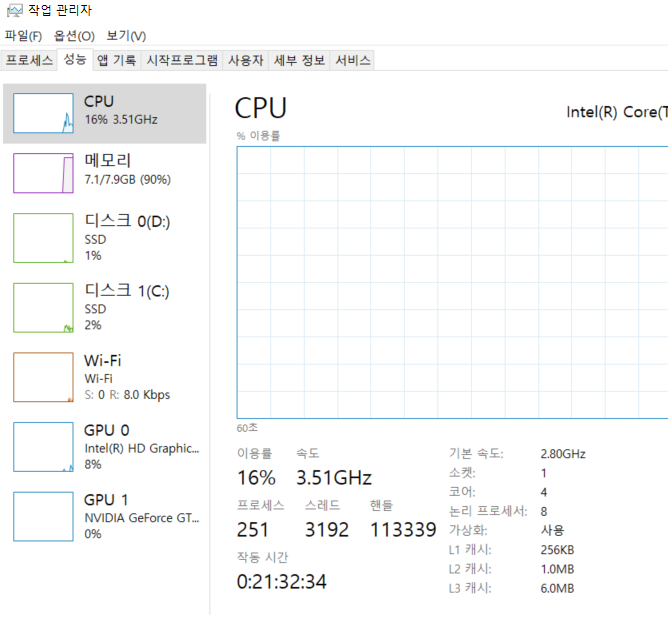

In [3]:
import sys

lis = [[0 for _ in range(10**4)] for __ in range(10**4)]
print(sys.getsizeof(lis))
100,000,000 (1억)
# 85176(8 kb)
[[0]] ==> 0.9바이트 약 1바이트

87616


In [ ]:
#  제자리 연산 바꿔치기를 하고 있다.

def laplacian(grid, out):
    np.copyto(out, grid)
    out *= -4
    out += np.roll(grid, +1, 0)
    out += np.roll(grid, -1, 0)
    out += np.roll(grid, +1, 1)
    out += np.roll(grid, -1, 1)


@profile
def evolve(grid, dt, out, D=1):
    laplacian(grid, out)
    out *= D * dt
    out += grid


페이지 폴트 

```

 Performance counter stats for 'python diffusion_numpy_memory.py':

     6,880,906,446      cycles                    #    2.886 GHz                      
     5,848,134,537      instructions              #    0.85  insn per cycle           
     1,077,550,720      cache-references          #  452.000 M/sec                    
       217,974,413      cache-misses              #   20.229 % of all cache refs      
     1,028,769,315      branches                  #  431.538 M/sec                    
         7,492,245      branch-misses             #    0.73% of all branches          
       2383.962679      task-clock (msec)         #    1.373 CPUs utilized          
            13,521      faults                    #    0.006 M/sec                  
            13,521      minor-faults              #    0.006 M/sec                  
               100      cs                        #    0.042 K/sec                  
                 8      migrations                #    0.003 K/sec                  

       1.736322099 seconds time elapsed

```

```
 Performance counter stats for 'python diffusion_numpy.py':
     
       216,490,683      cache-misses              #   20.800 % of all cache refs        
           403,282      faults                    #    0.138 M/sec                  
           403,282      minor-faults              #    0.138 M/sec                       

       2.274377105 seconds time elapsed
```



In [ ]:
# np.roll : 벡터를 새로 할당한다. + 필요한 것 이상의 기능을 많이 포함하고 있다
# 라이브러리가 아니라 하드코딩한다. shift 를 할 때 제자리 연산이 된다면 이득을 볼 수 있다. (단 캐시에 안올라간다는 전제하에)

def roll_add(rollee, shift, axis, out):
    if shift == 1 and axis == 0:
        out[1:, :] += rollee[:-1, :]
        out[0, :] += rollee[-1, :]
    elif shift == -1 and axis == 0:
        out[:-1, :] += rollee[1:, :]
        out[-1, :] += rollee[0, :]
    elif shift == 1 and axis == 1:
        out[:, 1:] += rollee[:, :-1]
        out[:, 0] += rollee[:, -1]
    elif shift == -1 and axis == 1:
        out[:, :-1] += rollee[:, 1:]
        out[:, -1] += rollee[:, 0]


def laplacian(grid, out):
    copyto(out, grid)
    multiply(out, -4.0, out)
    roll_add(grid, +1, 0, out)
    roll_add(grid, -1, 0, out)
    roll_add(grid, +1, 1, out)
    roll_add(grid, -1, 1, out)


@profile
def evolve(grid, dt, out, D=1):
    laplacian(grid, out)
    ne.evaluate("out*D*dt+grid", out=out)

# 6.5 numexpr:  제자리 연산을 더 빠르고 간편하게 하기


- 벡터연산 (마저도) 최적화 -> 캐시 미스와 임시 벡터 공간을 최소화
- 격자가 컴퓨터 캐시보다 크다면 캐시를 더 잘 이용할 수 있게 해주는 라이브러리. 

In [2]:
from numexpr import evaluate

# 6.6 scipy: 최적화 검증

- scipy의 laplace 함수와 직접 작성한 함수를 비교한다.
- 성능이 나아지지 않았는데 그 이유는 최적화 된 다른 부분에 비해 instruction, branches이 커져서.-->  범용적으로 작성되어 있기 때문이다.

그러므로 최적화를 하기 위해서는 현재 조건에 얼마나 부합하는 지를 확인할 필요가 있다.

# 6.7 행렬 최적화에서 얻은 교훈

초기화 과정에 필요한 관리 요소를 고려한다: 전체 실행횟수를 줄이고, 불필요한 자원 아끼고, 캐시에 관련 데이터만 채워지도록 할 수 있다.
- 메모리 할당
- 설정 파일 읽는 과정
- 프로그램이 실행되는 동안 필요한 값을 미리 계산하는 과정

데이터 지역성과 데이터를 CPU 에 빠르게 전달하는 것:
- 캐시 동작 방식을 이해하고 성능적으로 취약한 부분을 찾아 개선한다.

외부 라이브러리를 사용하는 것을 고려할 것.
- 외부 라이브러리는 저수준의 언어로 작성되어서 엄청나게 빠르게 동작하며 파이썬에서 쉽게 불러올 수 있다.

실험하기 전에 성능에 관한 가설을 세우고 성능을 측정하며 최적화 한다.

# 6.8 팬더스

## 6.8.1 팬더스 내부 모델

- 엑셀과 비슷한 모양 처음에는 dtype -> 여러 type에 대한 연산 지원
- 기본적으로 axis=1 단위로 적용
- 단일 스레드, GIL 을 비활성화 하면 병렬 연산이 가능해진다

## 6.8.2 여러 데이터 행에 함수 적용하기

- OLS: 데이터의 추세를 보는 방법 중 하나, 연속 데이터를 일정 기간으로 자르고 그 데이터들 사이의 관계를 파악한다 -> 반복 계산

ols_sklearn: 0.483 초
ols_lstsq(numpy): 0182초

In [ ]:
# 열 연산
import numpy as np
from sklearn.linear_model import LinearRegression

# 실수를 예방하는 라이브러리 때문에 (데이터 무결성) 오히려 속도가 느리다.
def ols_sklearn(row):
    """Solve OLS using scikit-learn's LinearRegression"""
    est = LinearRegression() 
    X = np.arange(row.shape[0]).reshape(-1, 1) # shape (14, 1)
    # note that the intercept is built inside LinearRegression
    est.fit(X, row.values) 
    m = est.coef_[0] # note c is in est.intercept_
    return m

def ols_lstsq(row):
    """Solve OLS using numpy.linalg.lstsq"""
    # build X values for [0, 13]
    X = np.arange(row.shape[0]) # shape (14,)
    ones = np.ones(row.shape[0]) # constant used to build intercept
    A = np.vstack((X, ones)).T # shape(14, 2)
    # lstsq returns the coefficient and intercept as the first result 
    # followed by the residuals and other items
    m, c = np.linalg.lstsq(A, row.values, rcond=-1)[0] 
    return m

def ols_lstsq_raw(row):
    """Variant of `ols_lstsq` where row is a numpy array (not a Series)"""
    X = np.arange(row.shape[0])
    ones = np.ones(row.shape[0])
    A = np.vstack((X, ones)).T
    m, c = np.linalg.lstsq(A, row, rcond=-1)[0] 
    return m



def ols_sm(row):
    # by default statsmodels fit uses 
    # https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse (pinv)
    # QR method is the alternative (this add 3s to execution in 50k rows test)
    sm_X = sm.add_constant(row.index)
    model = sm.OLS(row.values, sm_X)
    results = model.fit()
    #results.params # 2 params, C followed by m
    return results.params[1]

In [ ]:
# 행 연산: iterrows


# iloc을 이용한 intuitive한 코드
ms = []
for row_idx in range(df.shape[0]):
    row = df.iloc[row_idx]
    m = ols_lstsq(row)
    ms.append(m)
results = pd.Series(ms)


# iterrow를 이용한 더 pyconic한 코드: 그러나 여전히 반복마다 새로운 Series 객체를 만들어서 row에 저장하고 있다.( for문 )
assert_array_almost_equal(results_ols_lstsq, results)
print(f"Dereference with iloc {t2 - t1}")

ms = []
for row_idx, row in df.iterrows():
    m = ols_lstsq(row)
    ms.append(m)
results = pd.Series(ms)


In [ ]:
# apply   매서드 사용
# df.apply(조건) 을 사용해서 조건에 따라 각 요소에 연산을 적용시킬 수 있다.
# 이때 raw=True를 쓰면 Series를 만들지 않기 떄문에(원데이터 자체를 바꾼다.) 성능 향상


ms = df.apply(ols_lstsq, axis=1)
results = pd.Series(ms)

ms = df.apply(ols_lstsq_raw, axis=1, raw=True)
results = pd.Series(ms)

## 6.8.3 부분 결과를 이어 붙이지 않고 DataFrame 과 Series 만들기

- DataFrame을 연속으로 이어 붙여 결과를 만드는 방식이 왜 나쁜가? ==> concat을 할 때마다 새로 메모리를 할당 받아서(kernel과 통신) Series 객체를 이전보다 더 길게 만들어야한다.

In [ ]:


# iloc을 이용한 intuitive한 코드
ms = []
for row_idx in range(df.shape[0]):
    row = df.iloc[row_idx]
    m = ols_lstsq(row)
    ms.append(m)
results = pd.Series(ms) ---> 딱 한 번 Series 타입으로 바꾼다.


# concat 이용
results = None
for row_idx in range(df.shape[0]):
    row = df.iloc[row_idx]
    m = ols_lstsq(row)
    if results is None:
        results = pd.Series([m])  
    else:
        results = pd.concat((results, pd.Series([m]))) --------> 매번 Series 타입으로 바꿔서 result와 concat한다.

## 6.8.4 어떤 일을 하는 또 다른 (게다가 더 빠른) 방법

임의의 행에 9를 넣고 얼마나 빠르게 찾는 지 비교 (preprocessing 과 비슷한 환경)

In [ ]:
df['0_as_str'] = df[0].apply(lambda v: str(v))
# input: 1.30575763839322283274347393220120119

#일반적인 python 문자열 처리함수
def find_9(s): 
    """Return -1 if '9' not found else its location at position >= 0"""
    return s.split('.')[1].find('9') # 소숫점 아래자리 숫자 중에 9가 있으면 9숫자를 return 한다.

- pandas의 'str' 연산 이용.-> 파이썬 문자열 매서드를 Series에 적용한다.
- expand: split한 결과를 각각의 column으로 나눈다
- Series 객체를 계속 만들어야한다. 

%timeit df['0_as_str'].str.split('.', expand=True)[1].str.find('9') 
183 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

%timeit df['0_as_str'].apply(find_9)
51 ms ± 987 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

## 6.8.5 효율적인 팬더스 개발을 위한 조언